In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/software-bug-priroity-eda/__results__.html
/kaggle/input/software-bug-priroity-eda/__notebook__.ipynb
/kaggle/input/software-bug-priroity-eda/combined_data.csv
/kaggle/input/software-bug-priroity-eda/__output__.json
/kaggle/input/software-bug-priroity-eda/custom.css
/kaggle/input/software-bug-priroity-eda/__results___files/__results___65_0.png
/kaggle/input/software-bug-priroity-eda/__results___files/__results___8_0.png
/kaggle/input/software-bug-priroity-eda/__results___files/__results___67_0.png
/kaggle/input/software-bug-priroity-eda/__results___files/__results___93_0.png
/kaggle/input/software-bug-priroity-eda/__results___files/__results___20_0.png
/kaggle/input/software-bug-priroity-eda/__results___files/__results___53_1.png
/kaggle/input/software-bug-priroity-eda/__results___files/__results___14_0.png
/kaggle/input/software-bug-priroity-eda/__results___files/__results___66_0.png
/kaggle/input/software-bug-priroity-eda/__results___files/__results___45_0.png
/kaggle/i

In [2]:
import pandas as pd

# Load the data
data_df = pd.read_csv('/kaggle/input/software-bug-priroity-eda/combined_data.csv')

# Fill NaN values with empty strings in text fields
data_df['cleaned_title'] = data_df['cleaned_title'].fillna('')
data_df['cleaned_description'] = data_df['cleaned_description'].fillna('')


In [3]:
# Select the features
features_to_combine = ['Component', 'Status', 'Resolution', 'cleaned_title', 'cleaned_description']

# Convert non-text features to strings
data_df['Component'] = data_df['Component'].astype(str)
data_df['Status'] = data_df['Status'].astype(str)
data_df['Resolution'] = data_df['Resolution'].astype(str)

# Initialize lists to hold combined text and labels
sen_w_feats = []
labels = []

print('Combining features into strings...')

# For each sample, combine the features
for index, row in data_df.iterrows():
    combined = ''
    # Combine categorical features with [SEP] token
    combined += row['Component'] + ' [SEP] '
    combined += row['Status'] + ' [SEP] '
    combined += row['Resolution'] + ' [SEP] '
    
    # Append cleaned_title and cleaned_description
    combined += row['cleaned_title'] + ' [SEP] '
    combined += row['cleaned_description']
    
    # Add the combined text to the list
    sen_w_feats.append(combined)
    
    # Add the label if it's available (exclude test data where Priority is NaN)
    if pd.notnull(row['Priority']):
        labels.append(int(row['Priority']))
    else:
        labels.append(None)  # Placeholder for test data

print('  DONE.')
print('Dataset contains {:,} samples.'.format(len(sen_w_feats)))


Combining features into strings...
  DONE.
Dataset contains 54,322 samples.


In [4]:
data=pd.read_csv('/kaggle/input/isec-sdc-2025/test.csv')
test=pd.read_csv('/kaggle/input/isec-sdc-2025/train.csv')
data.shape,test.shape

((1328, 6), (52994, 7))

In [5]:
import numpy as np

# Create indices for train and validation sets
train_idx = data_df[data_df['Usage'] == 'Train'].index.tolist()
val_idx = data_df[data_df['Usage'] == 'Valid'].index.tolist()

# Extract labels for training and validation sets
train_labels = [labels[i] for i in train_idx]
val_labels = [labels[i] for i in val_idx]

# Sanity check
assert None not in train_labels, "Training labels contain None values."
assert None not in val_labels, "Validation labels contain None values."


In [6]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
max_len = 0

# For every sentence...
for sent in sen_w_feats:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Token indices sequence length is longer than the specified maximum sequence length for this model (873 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  10252


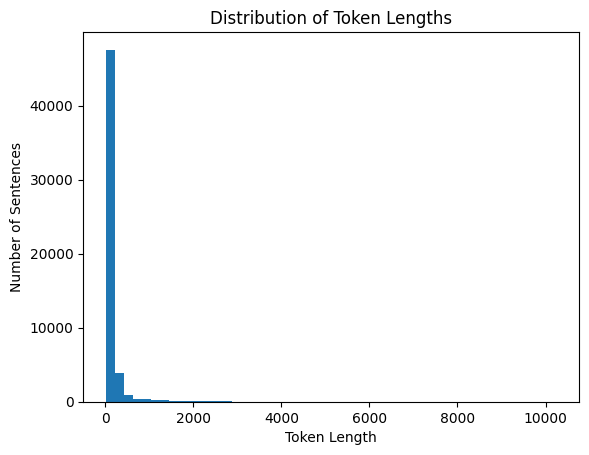

In [8]:
import matplotlib.pyplot as plt

token_lengths = [len(tokenizer.encode(sent, add_special_tokens=True)) for sent in sen_w_feats]
plt.hist(token_lengths, bins=50)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Number of Sentences')
plt.show()


In [9]:
import matplotlib.pyplot as plt
from ipywidgets import interact

# Token lengths data
#token_lengths = [len(tokenizer.encode(sent, add_special_tokens=True)) for sent in sen_w_feats]

# Function to update histogram interactively
def plot_histogram(bin_count=50):
    plt.figure(figsize=(14, 7))
    plt.hist(token_lengths, bins=bin_count, color='skyblue', edgecolor='black')
    plt.axvline(x=512, color='red', linestyle='--', label='BERT Max Length (512)')
    plt.title("Distribution of Token Lengths", fontsize=18, fontweight='bold')
    plt.xlabel("Token Length", fontsize=14)
    plt.ylabel("Number of Sentences", fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

# Create a slider for number of bins
interact(plot_histogram, bin_count=(10, 100, 10))


interactive(children=(IntSlider(value=50, description='bin_count', min=10, step=10), Output()), _dom_classes=(…

<function __main__.plot_histogram(bin_count=50)>

In [10]:
# Set the maximum sequence length
max_len = min(max_len, 512)
print('Adjusted max sequence length: ', max_len)


Adjusted max sequence length:  512


In [11]:
import torch


input_ids = []
attention_masks = []
token_type_ids_list = []

print('Encoding all reviews in the dataset...')

for sent in sen_w_feats:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens = True,
        max_length = max_len,
        truncation = True,
        padding = 'max_length',
        return_attention_mask = True,
        return_token_type_ids = True,  # Include token_type_ids
        return_tensors = 'pt',
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids_list.append(encoded_dict['token_type_ids'])

# Convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
token_type_ids_tensor = torch.cat(token_type_ids_list, dim=0)
labels_tensor = torch.tensor([label if label is not None else -1 for label in labels])

print('DONE.')


Encoding all reviews in the dataset...
DONE.


In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Create datasets
train_dataset = TensorDataset(
    input_ids[train_idx],
    attention_masks[train_idx],
    token_type_ids_tensor[train_idx],
    labels_tensor[train_idx]
)

val_dataset = TensorDataset(
    input_ids[val_idx],
    attention_masks[val_idx],
    token_type_ids_tensor[val_idx],
    labels_tensor[val_idx]
)

# Create DataLoaders
batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)


In [13]:
from transformers import BertForSequenceClassification, AdamW

# Load BertForSequenceClassification with the correct number of labels
num_labels = data_df['Priority'].nunique()  # Should be 5 for classes 0-4

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = num_labels,
    output_attentions = False,
    output_hidden_states = False,
)

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [14]:
from transformers import get_linear_schedule_with_warmup

# Optimizer parameters
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,  # Learning rate
    eps = 1e-8  # Epsilon
)

# Total number of training steps
epochs = 4
total_steps = len(train_dataloader) * epochs

# Scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
from sklearn.metrics import f1_score

def compute_metrics(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    f1 = f1_score(labels_flat, preds_flat, average='macro')
    return f1


In [16]:
import time
import datetime
import numpy as np
from sklearn.metrics import f1_score, matthews_corrcoef, classification_report
from tqdm.notebook import tqdm  # For progress bars

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

# Set seed for reproducibility
seed_val = 42
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
np.random.seed(seed_val)

# Training parameters
epochs = 4
gradient_accumulation_steps = 1  # Set to >1 if using gradient accumulation

# Total number of training steps
total_steps = len(train_dataloader) // gradient_accumulation_steps * epochs

# Initialize the optimizer and scheduler
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

# Training loop
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')
    
    t0 = time.time()
    total_train_loss = 0
    model.train()
    
    # For each batch of training data
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)
        
        # Clear previously calculated gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            b_input_ids,
            token_type_ids=b_token_type_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Accumulate the loss
        total_train_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        
        # Update learning rate
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    
    print("")
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")
    
    # Validation
    print("")
    print("Running Validation...")
    t0 = time.time()
    
    model.eval()
    
    # Tracking variables
    total_eval_loss = 0
    predictions, true_labels = [], []
    
    for batch in tqdm(validation_dataloader, desc="Validation"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)
        
        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=b_token_type_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )
        
        loss = outputs.loss
        logits = outputs.logits
        
        total_eval_loss += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        predictions.append(logits)
        true_labels.append(label_ids)
    
    # Compute the F1 score over the entire validation set
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    
    avg_val_f1 = f1_score(flat_true_labels, flat_predictions, average='macro')
    mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation F1 Score (Macro): {avg_val_f1:.2f}")
    print(f"  Validation MCC: {mcc:.2f}")
    print(f"  Validation took: {validation_time}")
    
    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. F1': avg_val_f1,
            'Valid. MCC': mcc,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")



======== Epoch 1 / 4 ========
Training...


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/1325 [00:00<?, ?it/s]


  Average training loss: 1.00
  Training epoch took: 1:03:25

Running Validation...


Validation:   0%|          | 0/332 [00:00<?, ?it/s]

  Validation Loss: 0.94
  Validation F1 Score (Macro): 0.35
  Validation MCC: 0.32
  Validation took: 0:05:23

======== Epoch 2 / 4 ========
Training...


Training:   0%|          | 0/1325 [00:00<?, ?it/s]


  Average training loss: 0.90
  Training epoch took: 1:03:32

Running Validation...


Validation:   0%|          | 0/332 [00:00<?, ?it/s]

  Validation Loss: 0.90
  Validation F1 Score (Macro): 0.38
  Validation MCC: 0.37
  Validation took: 0:05:23

======== Epoch 3 / 4 ========
Training...


Training:   0%|          | 0/1325 [00:00<?, ?it/s]


  Average training loss: 0.84
  Training epoch took: 1:03:34

Running Validation...


Validation:   0%|          | 0/332 [00:00<?, ?it/s]

  Validation Loss: 0.89
  Validation F1 Score (Macro): 0.42
  Validation MCC: 0.38
  Validation took: 0:05:22

======== Epoch 4 / 4 ========
Training...


Training:   0%|          | 0/1325 [00:00<?, ?it/s]


  Average training loss: 0.78
  Training epoch took: 1:03:34

Running Validation...


Validation:   0%|          | 0/332 [00:00<?, ?it/s]

  Validation Loss: 0.91
  Validation F1 Score (Macro): 0.42
  Validation MCC: 0.38
  Validation took: 0:05:23

Training complete!
Total training took 4:35:37 (h:mm:ss)


In [17]:
# Prediction on validation set
print('Running evaluation on validation set...')

model.eval()

predictions, true_labels = [], []

for batch in tqdm(validation_dataloader, desc="Validation"):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_token_type_ids = batch[2].to(device)
    b_labels = batch[3].to(device)
    
    with torch.no_grad():
        outputs = model(
            b_input_ids,
            token_type_ids=b_token_type_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )
    
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# For each sample, pick the label with the highest score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Calculate the macro F1 score
from sklearn.metrics import f1_score, classification_report

f1 = f1_score(flat_true_labels, flat_predictions, average='macro')
print('Validation F1 Score (Macro): %.3f' % f1)

# Print classification report
print('\nClassification Report:\n')
print(classification_report(flat_true_labels, flat_predictions))


Running evaluation on validation set...


Validation:   0%|          | 0/332 [00:00<?, ?it/s]

    DONE.
Validation F1 Score (Macro): 0.424

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.45      0.48      1789
           1       0.43      0.30      0.35      1882
           2       0.74      0.89      0.80      6231
           3       0.46      0.11      0.18       457
           4       0.54      0.21      0.31       240

    accuracy                           0.66     10599
   macro avg       0.54      0.39      0.42     10599
weighted avg       0.63      0.66      0.63     10599



Matthews Correlation Coefficient: 0.376


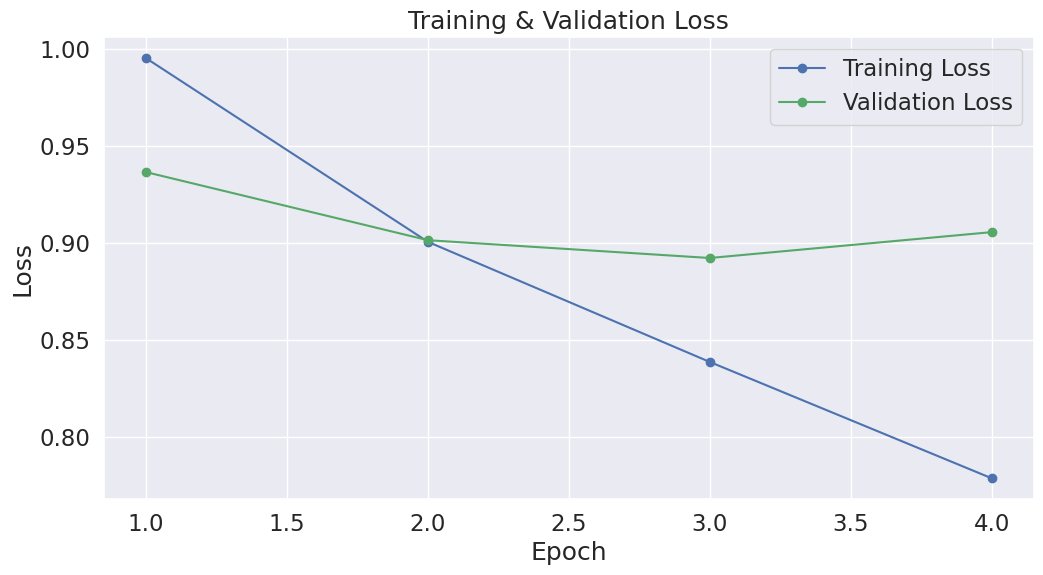

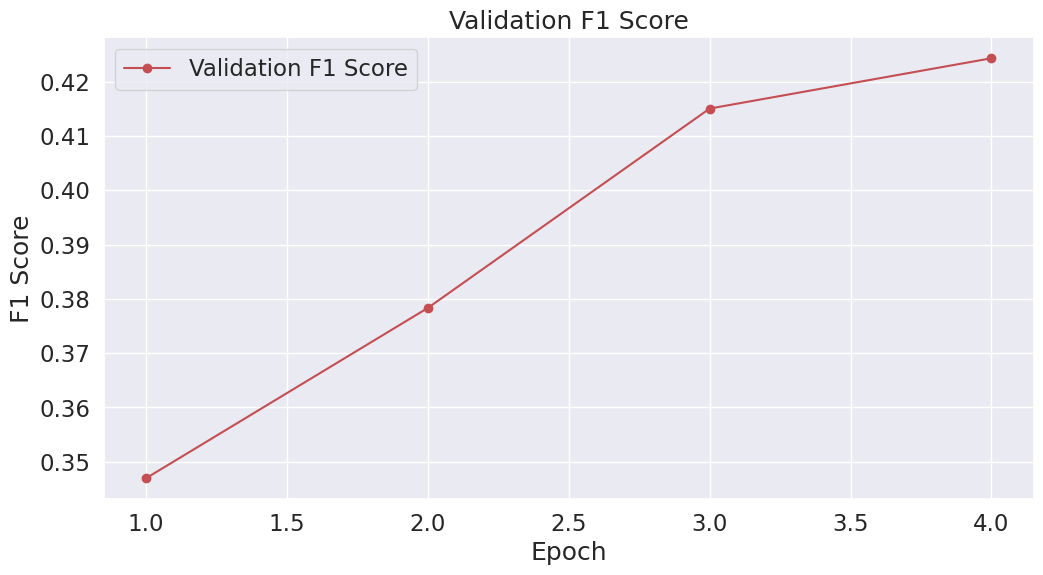

In [18]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Matthews Correlation Coefficient: %.3f' % mcc)

import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(training_stats).set_index('epoch')

# Use plot styling from seaborn.
import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot F1 Score
plt.plot(df_stats['Valid. F1'], 'r-o', label="Validation F1 Score")

# Label the plot.
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.show()


In [19]:
import pandas as pd

# Load the combined data
data_df = pd.read_csv('/kaggle/input/software-bug-priroity-eda/combined_data.csv')

# Filter the test data
test_df = data_df[data_df['Usage'] == 'Test'].copy()

# Reset index
test_df.reset_index(drop=True, inplace=True)

print('Number of test samples:', len(test_df))


Number of test samples: 1328


In [20]:
# Fill NaN values with empty strings in text fields
test_df['cleaned_title'] = test_df['cleaned_title'].fillna('')
test_df['cleaned_description'] = test_df['cleaned_description'].fillna('')

# Ensure categorical features are strings
test_df['Component'] = test_df['Component'].astype(str)
test_df['Status'] = test_df['Status'].astype(str)
test_df['Resolution'] = test_df['Resolution'].astype(str)


In [21]:
# Initialize list to hold combined text
test_sentences = []

print('Combining features into strings for test data...')

# For each sample, combine the features
for index, row in test_df.iterrows():
    combined = ''
    # Combine categorical features with [SEP] token
    combined += row['Component'] + ' [SEP] '
    combined += row['Status'] + ' [SEP] '
    combined += row['Resolution'] + ' [SEP] '
    
    # Append cleaned_title and cleaned_description
    combined += row['cleaned_title'] + ' [SEP] '
    combined += row['cleaned_description']
    
    # Add the combined text to the list
    test_sentences.append(combined)

print('  DONE.')
print('Number of test sentences:', len(test_sentences))


Combining features into strings for test data...
  DONE.
Number of test sentences: 1328


In [22]:
# If not already loaded:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Loading BERT tokenizer...


In [23]:
max_len=512

import torch

test_input_ids = []
test_attention_masks = []
test_token_type_ids = []

print('Encoding test data...')

for sent in test_sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens = True,
        max_length = max_len,
        truncation = True,
        padding = 'max_length',
        return_attention_mask = True,
        return_token_type_ids = True,
        return_tensors = 'pt',
    )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
    test_token_type_ids.append(encoded_dict['token_type_ids'])

# Convert lists to tensors
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_token_type_ids = torch.cat(test_token_type_ids, dim=0)

print('DONE.')


Encoding test data...
DONE.


In [24]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

# Create the TensorDataset
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_token_type_ids)

# Create the DataLoader
batch_size = 32  # Same as used during training

test_dataloader = DataLoader(
    test_dataset,
    sampler = SequentialSampler(test_dataset),
    batch_size = batch_size
)


In [25]:
# Put model in evaluation mode
model.eval()
# Tracking variables
predictions = []

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Predict
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from the dataloader
    b_input_ids, b_input_mask, b_token_type_ids = batch
    
    # Telling the model not to compute or store gradients
    with torch.no_grad():
        # Forward pass, get logits output
        outputs = model(
            b_input_ids,
            token_type_ids=b_token_type_ids,
            attention_mask=b_input_mask
        )
    
    logits = outputs.logits
    
    # Move logits to CPU
    logits = logits.detach().cpu().numpy()
    
    # Store predictions
    predictions.append(logits)

print('    DONE.')


Predicting labels for 1,328 test sentences...
    DONE.


In [26]:
# Combine the predictions
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (class) with the highest score
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

print('Predicted labels:', predicted_labels)


Predicted labels: [1 0 0 ... 4 2 2]


In [27]:
# Create a DataFrame with 'Issue-id' and 'Predicted Priority'
submission_df = pd.DataFrame({
    'Issue-ID': test_df['Issue_id'],
    'Predicted Priority': predicted_labels
})

# Ensure 'Issue-ID' is of integer type (if necessary)
submission_df['Issue-ID'] = submission_df['Issue-ID'].astype(int)

# Display the first few rows
print(submission_df.head())


   Issue-ID  Predicted Priority
0      6578                   1
1      8050                   0
2      5281                   0
3      7871                   1
4      2411                   2


In [28]:
# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)


In [29]:
# Create a directory to save the model and tokenizer
output_dir = './model_save/'

# If the directory does not exist, create it
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the trained model
print("Saving model to %s" % output_dir)
model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [30]:
import os

# List the files in the output directory
files = os.listdir(output_dir)
print("Saved files:", files)


Saved files: ['vocab.txt', 'model.safetensors', 'config.json', 'tokenizer_config.json', 'special_tokens_map.json']


In [31]:
# Save optimizer and scheduler states
optimizer_save_path = os.path.join(output_dir, 'optimizer.pt')
scheduler_save_path = os.path.join(output_dir, 'scheduler.pt')

torch.save(optimizer.state_dict(), optimizer_save_path)
torch.save(scheduler.state_dict(), scheduler_save_path)
